Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=False, do_fovea=False, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=1998, batch_size=80, num_workers=4, in_memory=True, model_name='resnet101', do_scratch=False, num_epochs=10, n_train_stop=40960, n_val_stop=5120, lr=0.001, delta1=0.05, delta2=0.0, weight_decay=0.003, label_smoothing=0.0001, shuffle=True, verbose=True)

In [2]:
fovea.all_model_names

['resnet18', 'resnet50', 'resnet101']

# testing different networks

In [3]:
args = fovea.Params()
from retinoto_py import all_model_names

json_filename = args.data_cache / '13_model_comparison.json'

# %rm {json_filename}  # FORCING RECOMPUTE

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for do_mask in [True, False]:
        # for dataset in ['full']:# <HACK until bbox is finished> fovea.all_datasets:
        for dataset in fovea.all_datasets:
            args = fovea.Params(do_mask=do_mask)
            VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
            val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=args.n_val_stop)
            val_loader = fovea.get_loader(args, val_dataset)
            for model_name in fovea.all_model_names:
                args.model_name = model_name
                model = fovea.load_model(args)
                param_stats = fovea.count_parameters(model)
                total_layers = fovea.count_layers(model)
                tic = fovea.time.time()
                accuracy = fovea.get_validation_accuracy(args, model, val_loader, f"Model {args.model_name}\t dataset: {dataset}\t(do_mask={do_mask})")            
                toc = fovea.time.time()
                this_result = { 'model_name': model_name,
                                'do_mask': do_mask,
                                'dataset': dataset,
                                'accuracy': accuracy,
                                'wall_clock_time': toc-tic,
                                'total_parameters': param_stats['total_parameters'],
                                'trainable_parameters': param_stats['trainable_parameters'],
                                'total_layers': total_layers}
                all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)


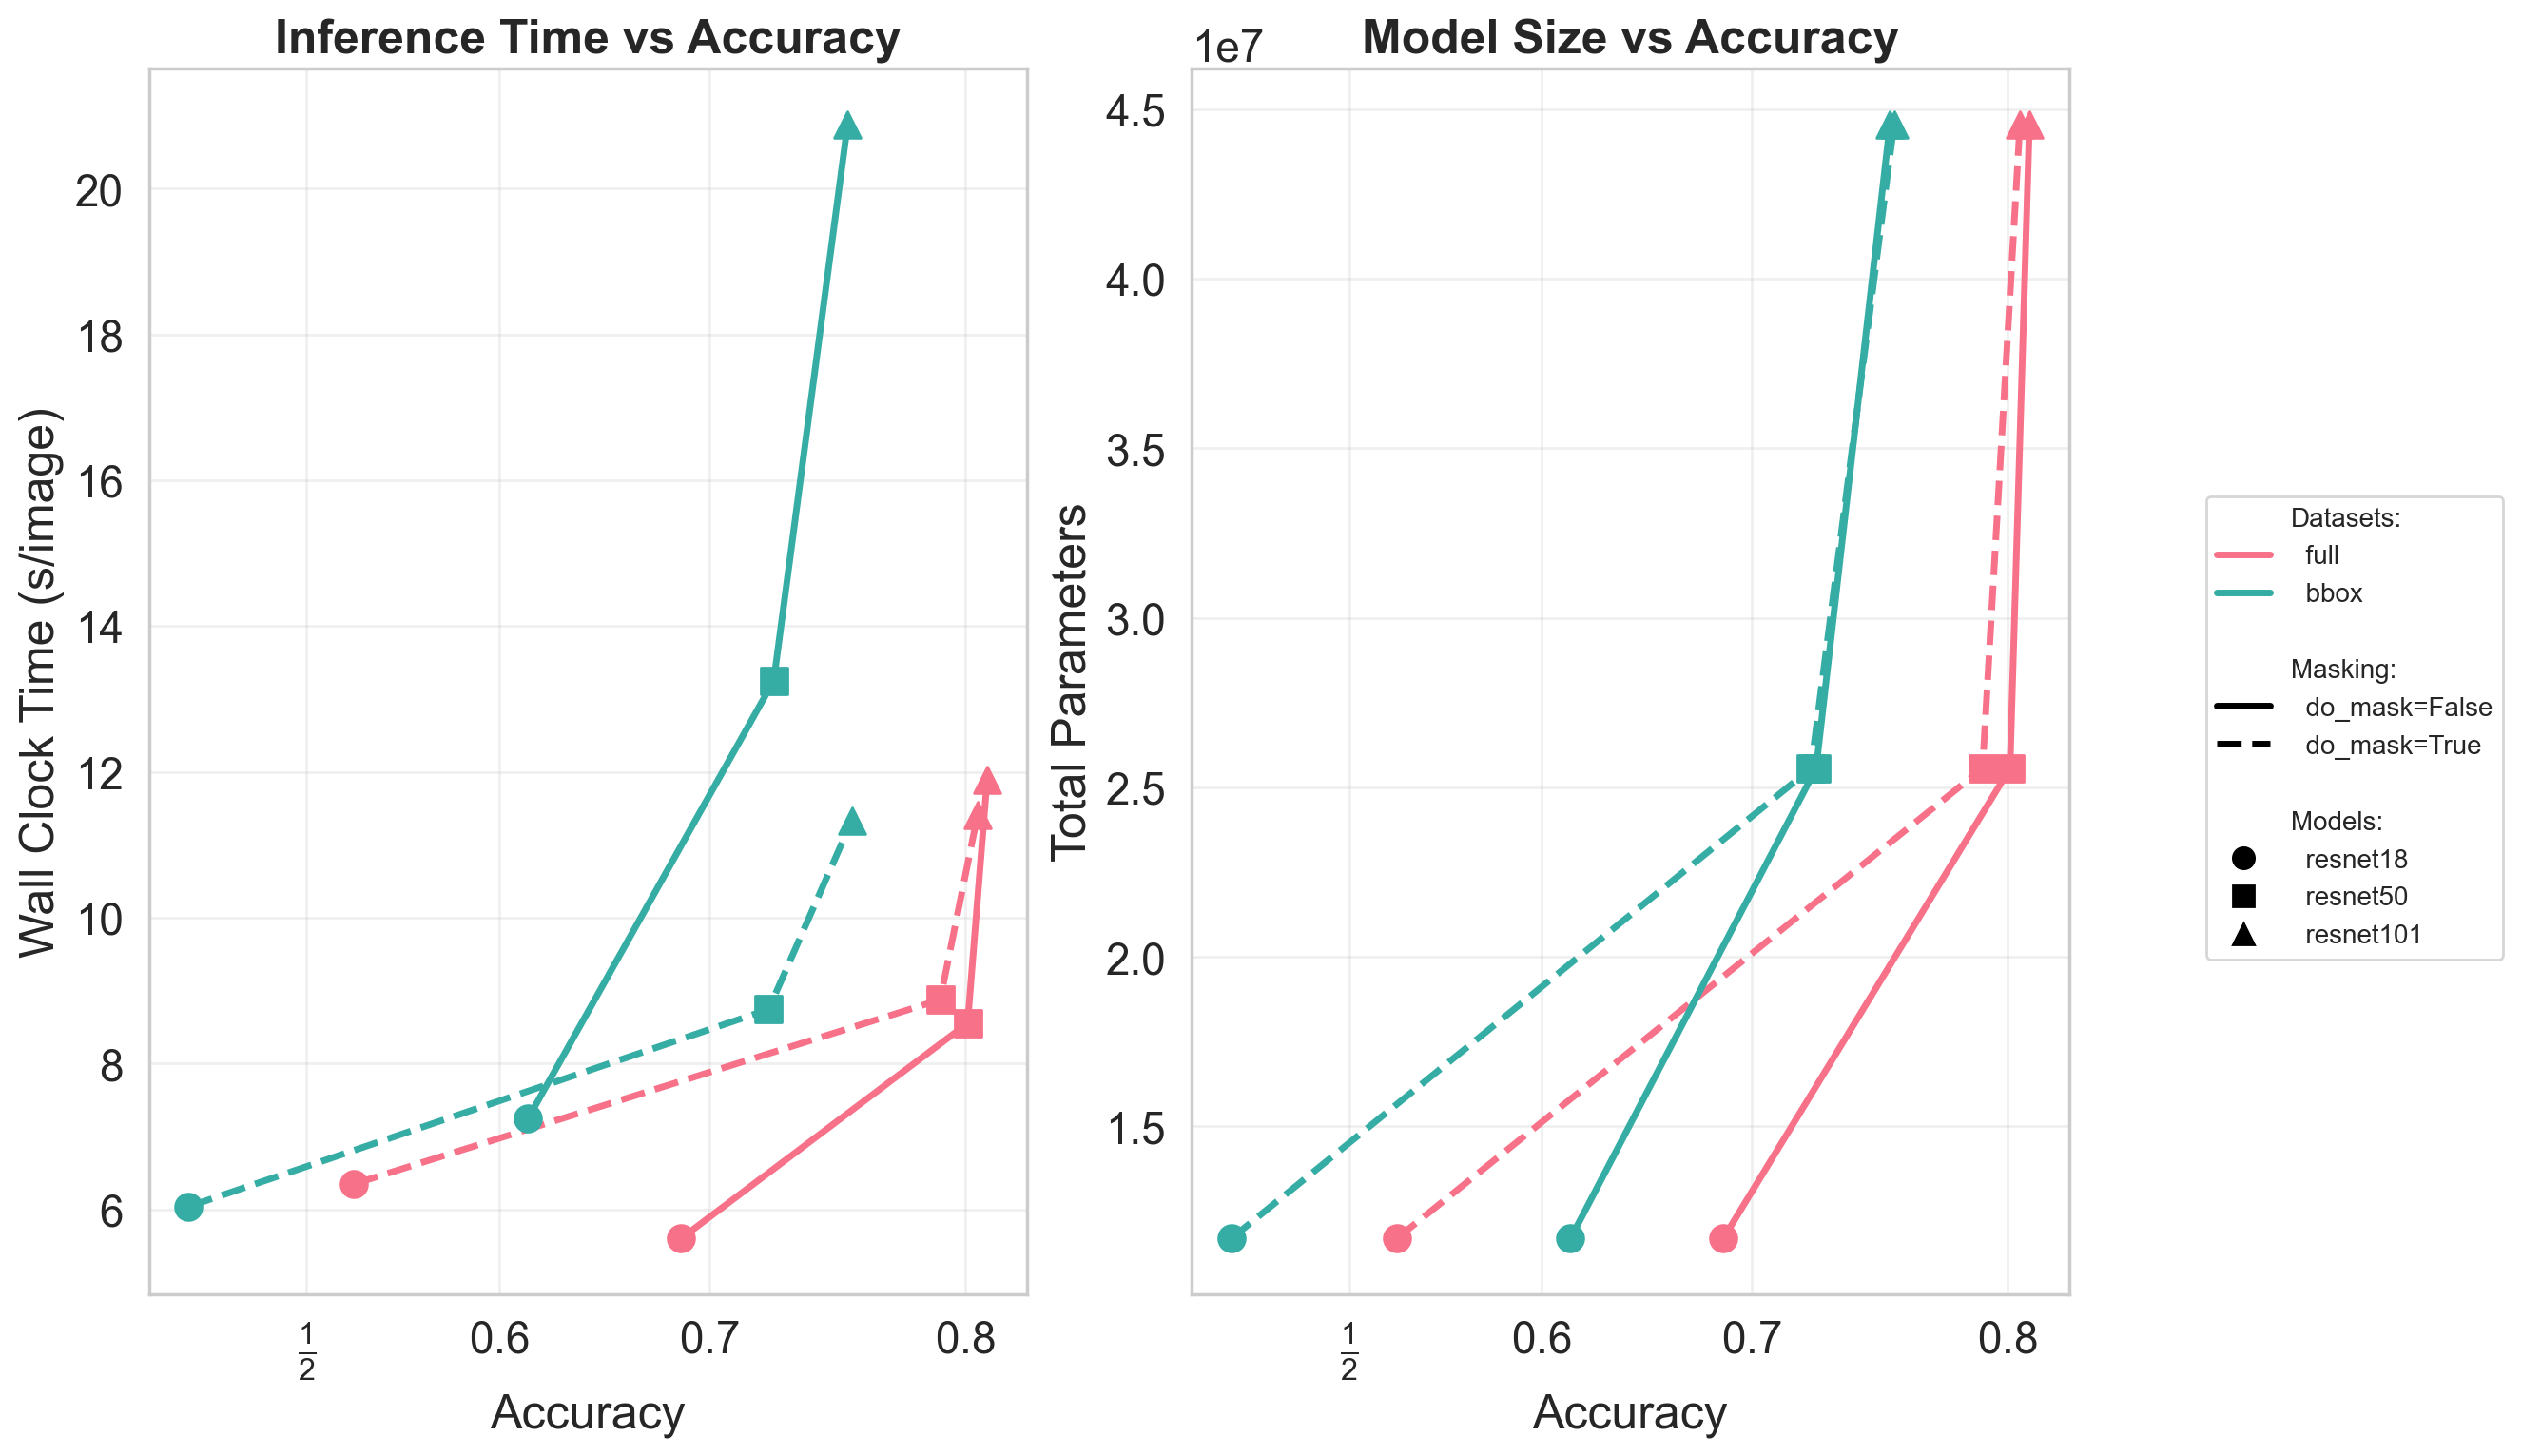

In [ ]:
fig, ax = fovea.plot_model_comparison(results, fovea.all_model_names, fovea.all_datasets, do_masks=[True, False], figures_folder=args.figures_folder, save_name='13_model_comparison', exts=['svg'])
